<a href="https://colab.research.google.com/github/oriol-pomarol/codegeo_workshops/blob/main/0_training_your_first_ml_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Training your first ML model - a complete beginner's guide

## Setting up the Pyhon environment - not necessary for Colab users


1. Install miniforge (https://github.com/conda-forge/miniforge#install) or your preferred conda distribution.

2. Download the conda environment file from the Coding/ML group, and create conda environment from it.
```bash
    conda env create -f environment.yml
```

3. Activate the environment. You are now ready to go!
```bash
    conda activate pyenv
````

## 0.1 Problem definition



Our goal here is to predict the river discharge utilizing meterological variables such as evapotranspiration, precipitation, and temperature in the catchment area. We will fit a machine learning model and a linear regression for this task, and compare them.

**Dataset**: The data that we are going to use contains observed daily discharge data from Global Runoff Data Centre (GRDC) and meterological variables used as input by PCR-GLOBWB 2.0 for the period 1980 to 2000 from a station in Basel, Switzerland.

![picture](https://drive.google.com/uc?export=view&id=15qPBhlvbgIXsqAnnxN7BnLuLVKVeICH3)


### Importing libraries

Before we get started, the first step is to import the libraries that we are going to use. These include:


*   **pandas**: Fast, powerful, flexible and easy to use data analysis and manipulation tool.
*   **matplotlib**: Standard Python library for creating all sorts of plots and visualizations.

*   **scikit-learn**: Library containing simple and efficient tools for predictive data analysis.



In [33]:
import pandas as pd
import matplotlib
import sklearn

### Downloading the data

Dataset is available on https://github.com/oriol-pomarol/final_thesis_project/tree/main/data and can be easily read using pandas.

In [34]:
input_data = pd.read_csv("https://raw.githubusercontent.com/oriol-pomarol/final_thesis_project/main/data/pred_basel.csv", delimiter=",", on_bad_lines='skip', index_col=0)
output_data = pd.read_csv("https://raw.githubusercontent.com/oriol-pomarol/final_thesis_project/main/data/q_basel.csv", delimiter = ",", on_bad_lines='skip', index_col=0)

We are interested only in certain variables from this dataset, so we extract those from the original dataframes. From the input variables we will keep only the meteorological variables, i.e., precipitation (p), temperature (t) and evapotranspiration (et), and from the output variables only the observations (obs).

In [35]:
input_data = input_data[['p', 't', 'et']]
output_data = output_data[['obs']]

Lastly, we visualize the dataframes to confirm that everything is working as expected.

In [36]:
input_data

,p,t,et
datetime,,,
1981-01-01,0.003536,-0.250816,0.000405
1981-01-02,0.003379,2.172385,0.000472
1981-01-03,0.017352,5.165919,0.000576
1981-01-04,0.022734,1.019687,0.000443
1981-01-05,0.005195,-2.055391,0.000364
...,...,...,...
2000-12-27,0.001242,2.119268,0.000492
2000-12-28,0.000561,-0.594725,0.000413
2000-12-29,0.002027,-3.251007,0.000348


In [37]:
output_data

,obs
datetime,
1981-01-01,670.000
1981-01-02,647.000
1981-01-03,727.000
1981-01-04,1363.000
1981-01-05,1202.000
...,...
2000-12-27,662.035
2000-12-28,656.253
2000-12-29,652.150


## 0.2 Getting the data ML-ready


### Cleaning the data

The scikit-learn (sklearn) package for machine learning models is not equipped to handle null or **missing values** in the data. Therefore it is necessary to pre-process the dataset by removing these null values before applying any machine learning algorithms.

To do so, we use the *isna()* function from pandas to check what rows have mising data for each variable, and then we apply *sum()* to obtain the total number of missing values.

In [38]:
output_data.isna().sum()

obs    0
dtype: int64

In [39]:
input_data.isna().sum()

p     0
t     0
et    0
dtype: int64

Luckily, in this case both inputs and outputs do not contain missing data and can be directly utilized in machine learning model. To know how to deal with missing data, keep tuned for a future workshop on the topic!

Additionally, in the data cleaning process one usually also checks if there are duplicate or outlier values and deletes them, but in this case we trust that our data is already good enough.

### Data Visualization




Reviewing statistical measures alone may not provide a comprehensive understanding of data. Plotting the variables can help in identifying patterns, trends, and potential outliers. Visualizations can also ehance decision-making in model selection (e.g. linear vs non-linear).

Let's first plot the input variables.

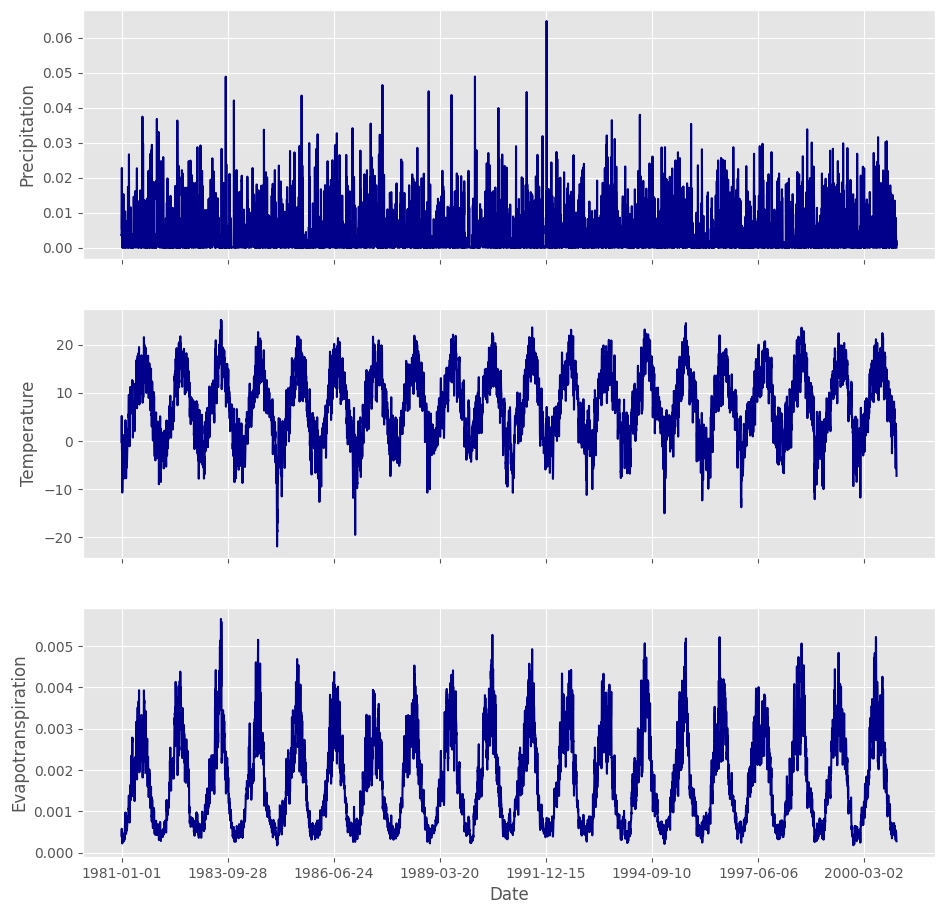

In [40]:
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')

axes = input_data.plot(use_index=True, y=["p", "t", "et"], figsize=(11, 11),
                       subplots=True, sharex=True, xlabel="Date", legend=False,
                       color='darkblue')
axes[0].set_ylabel('Precipitation')
axes[1].set_ylabel('Temperature')
axes[2].set_ylabel('Evapotranspiration')
plt.show()

And now we can plot the output variable, that is, the discharge.

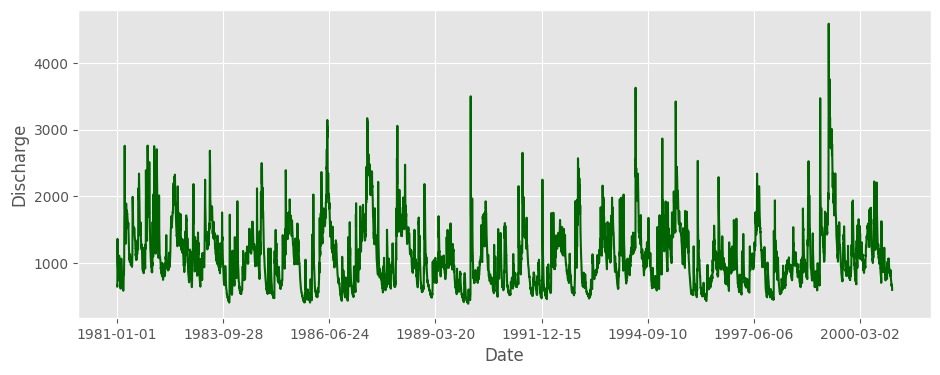

In [41]:

output_data.plot(use_index = True, y = "obs", figsize=(11, 4), xlabel = "Date",
                 ylabel="Discharge", legend = False, color = 'darkgreen')
plt.show()

Upon visual inspection, all the variables appear to be in order and consistent, following the expected seasonal trend.


### Splitting the dataset into train and test dataset



In machine learning, splitting the dataset into training and testing dataset is and important step to assess the model perfomance and generalization on new, unseen data.

**Training** set is utilized to train the model and let model the learn relationship between depedent variable (discharge in our case) and indepedent variables (precipitation, temperature and evapotransporation).

**Test** set is used to evaluate the model perfomance and model ability to predicit unseen data.



> Attention: In traditional modelling, what we define here as testing is usually referred as model validation, but in ML this term has another meaning, so be careful when using it!


Several techniques exist to split the dataset into training and testing, but here we are going to use a temporal 90-10 split, so the first 90% of the data will be used for training and the remaining 10% for testing. Usually you want to find a balance so that there is enough training data for the model while still having a representative enough test sample.

We could do this manually, but it is easier to use *sklearn*, which already has the function *train_test_split()* to do so automatically.

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(input_data, output_data, test_size = 0.1, shuffle=False)

## 0.3 Training the model

We are going to train the model using default parameters. However one can also change the parameters (also called hyperparameters) of model for maximum perfomance. Keep posted for a coming hyperparameter workshop!

In *sklearn*, we first define which type of ML model we want to use, and then we use *.fit()* to train it on our data. We will use a very common algorithm, Random Forest, in its "Regressor" version (i.e., for continuous output).

In [43]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=10)
rf_model.fit(X_train, y_train)

<ipython-input-43-e3093faf26ea>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=10)

For comparison, let's "train" a linear regression model. It is also included in the sklearn package, so we can use the same syntax.

In [44]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

## 0.4 Evaluating the model

### Making the predictions

Now that we have already trained our models, it is time to make predictions on the test input data, which we have not used so far, to obtain an unbiased estimate of our model's performance.

In [45]:
rf_prediction = rf_model.predict(X_test)
lin_prediction = lin_model.predict(X_test)

Let's visualize these predictions against the observed values that we have stored in the *y_test* variable.

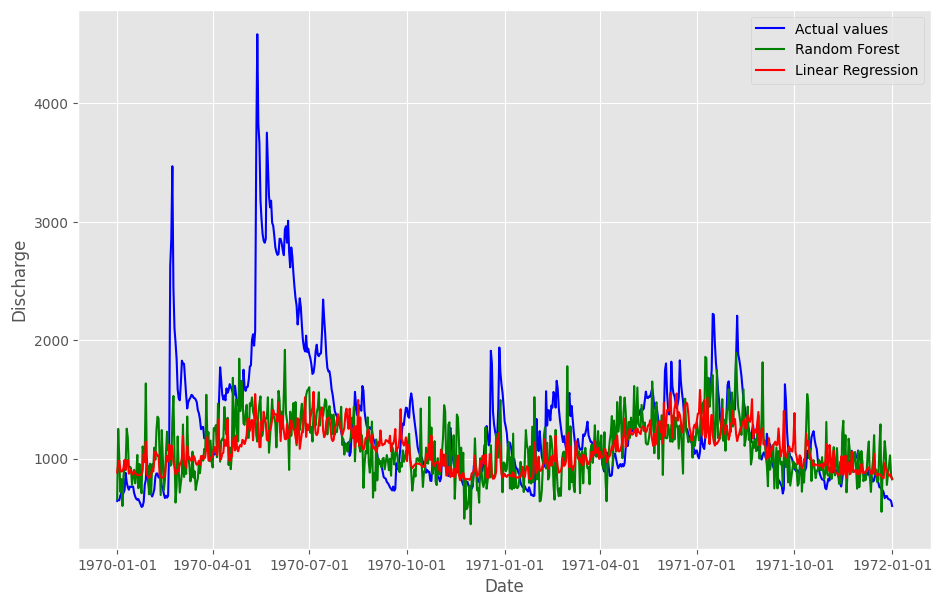

In [46]:
import matplotlib.dates as mdates

plt.figure(figsize=(11, 7))
plt.plot(y_test.index, y_test, label='Actual values', color='b')
plt.plot(y_test.index, rf_prediction, label='Random Forest', color='g')
plt.plot(y_test.index, lin_prediction, label='Linear Regression', color='r')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

From this plot it is not immediately obvious which model is performing best. We are able to plot our results here because we have a relatively small dataset, but usually for evaluating the models we will need to resort to metrics.

### Checking the metrics

To compare the performance of our RF model with the linear regression, we are going to use a few common metrics: r squared, mean absolute error and mean squared error. Remember that for r squared higher is better, but for the rest it is the opposite.

We could define the metrics ourselves, but since they are commonly used ones we can directly import them from the *sklearn* library. We finally compile the results in a nice *pandas* Dataframe.

In [47]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate metrics for Random Forest
rf_r2 = r2_score(y_test, rf_prediction)
rf_mae = mean_absolute_error(y_test, rf_prediction)
rf_rmse = mean_squared_error(y_test, rf_prediction, squared=False)

# Calculate metrics for Linear Regression
lin_r2 = r2_score(y_test, lin_prediction)
lin_mae = mean_absolute_error(y_test, lin_prediction)
lin_rmse = mean_squared_error(y_test, lin_prediction, squared=False)

# Create DataFrame to store the metrics
metrics = pd.DataFrame({
    'r²': [lin_r2, rf_r2],
    'MAE': [lin_mae, rf_mae],
    'RMSE': [lin_rmse, rf_rmse]
}, index=['Linear Regression', 'Random Forest'])

# Round to different number of decimal places for each column
metrics = metrics.round({'r²': 4, 'MAE': 1, 'RMSE': 1})
metrics

,r²,MAE,RMSE
Linear Regression,0.0670,331.5,536.1
Random Forest,0.0732,345.0,534.3


From the r squared metric and the RMSE, we can see that our Random Forest model is performing slightly better than a simple linear regression but, on the other hand, it has a worse MAE. This indicates that our Random Forest model is doing worse on average, but it better manages to avoid really high errors.

From these results, we cannot say that the RF model is doing significantly better than the linear alternative. Let's try to see what is going wrong in our model using some more plots.

### Predicted vs Actual plot

 A scatter plot of Predicted vs Actual values offers a lot of information on how our model is performing. For an ideal model, all points would be at the diagonal line (predicted=actual), so the farther away they are the bigger the error. Points above the diagonal line indicate that the model is overestimating, and the opposite for below.

It is very easy to make such a plot using *matplotlib*. Make sure to also print the diagonal!

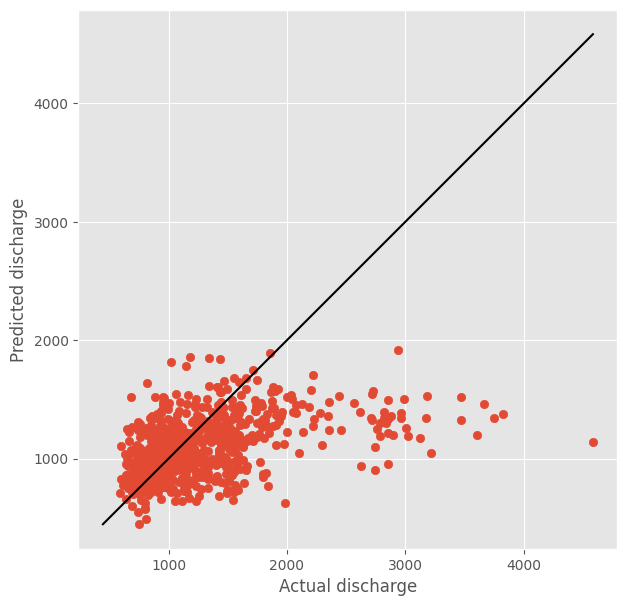

In [49]:
plt.figure(figsize=(7,7))

# Make the plot
min_val = min(min(y_test.values), min(rf_prediction))
max_val = max(max(y_test.values), max(rf_prediction))
plt.scatter(y_test, rf_prediction)
plt.plot([min_val, max_val], [min_val, max_val], color='black')

# Labels
plt.xlabel('Actual discharge')
plt.ylabel('Predicted discharge')

# Equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

It is quite clear from this plot that our model really struggles to predict the high discharge measurements, which it consistently underestimates. Additionally, the fact that most points are relatively far from the diagonal line also indicates us that it is not a very precise model, even for lower discharge values.

## 0.5 Final remarks

Wait, what, that's it? All of this fuzz about ML models and now it even struggles to do a simple task? Well, of course not! This was just a tutorial to train your first ML model, we cannot expect it to have an amazing performance out of the box. There are many more tricks that we can do on the data and the model itself to improve our performance, so keep posted in our Teams channel for more workshops!  :)

For now, why don't you try to fit another model from the *scikit-learn* library? What about a neural networkfor example? You will need to import it from [*sklearn.neural_network*](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor). It is your time to code, you can now copy and adapt the code above as necessary to train your first ever ML model!

In [48]:
# Define and fit the model


# Make predictions


# Plot the results